<a href="https://colab.research.google.com/github/big-muzzy/StyleTransfer/blob/master/StyleTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf #Импортируем tensorflow
import datetime, os #Для подсчета времени и работы с файловой системой
import numpy as np #Для работы с матрицами 
from tensorflow.keras import utils #Для работы с категориальными данными 
import sys #Для спецаильно вывода
import matplotlib.pyplot as plt #Для виузализации 
import random #Для генерации случайных чисел 
from PIL import Image

from types import SimpleNamespace

In [2]:
from google.colab import drive
drive.mount('content')

Drive already mounted at content; to attempt to forcibly remount, call drive.mount("content", force_remount=True).


In [3]:
config = SimpleNamespace() # Создаем базовый класс пространства имен
config.content = '/content/content/My Drive/pic/source.jpg' # наша основная картинка
config.style = '/content/content/My Drive/pic/picasso.jpg' # наша стилизованная картинка
config.maxSize = 500 # максимально допустимый размер изображения
config.totalStep = 1000 # общее количество шагов за эпоху
config.step = 100 # шаг
config.sampleStep = 100 # шаг для сохранения образца
config.styleWeight = 100 #вес на стиль
config.lr = 0.005 

Функция для загрузки изображений

In [4]:
def load_image(image_path, maxSize=None, shape=None):
    # Загружаем изображение
    image = Image.open(image_path)
    
    # Если указан максимальный размер, то меняем размер нашего изображения
    if maxSize:
        scale = maxSize / max(image.size) # задаем масштаб для преобразования размера
        size = np.array(image.size) * scale # масштабированный размер
        image = image.resize(size.astype(int), Image.ANTIALIAS) # преобразуем 
        
    # Если указана форма изображением, меняем форму
    if shape:
        image = image.resize(shape, Image.LANCZOS)

    return image

In [5]:
content = load_image(config.content, maxSize=config.maxSize)
style = load_image(config.style, shape=[content.size[0], content.size[1]])

Посмотрим картинки. Целевую и стиль для наложения. 

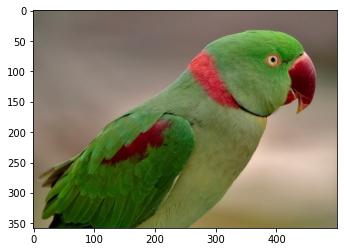

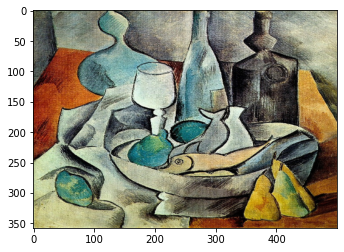

In [6]:
plt.imshow(content)
plt.show()
plt.imshow(style)
plt.show()

Загружаем предобученную VGG19

In [7]:
vgg16Model = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
vgg16Model.trainable = False

In [8]:
def transformImage(img):
  result = np.array(img, dtype='float32')
  result = result / 255.0
  result = result.reshape((1,)+ result.shape)
  return result
  

Преобразуем в NumPy

In [9]:
npContent = transformImage(content)
npStyle = transformImage(style)
print(npContent.shape)
print(npStyle.shape)


(1, 358, 500, 3)
(1, 358, 500, 3)


Создадим свою модель на основе предобученной

In [10]:
class myModel(object):
  def __init__(self, baseModel, layersList):
    baseModel.trainable = False
    self.baseModel = baseModel
    self.layers = layersList

  def __call__(self, inputs):

    features = [] # Извлекаем по индексам, которые мы прописали выше, feature map из сетки
    output = inputs
    for layerIndex in range(len(self.baseModel.layers)):
      output = self.baseModel.get_layer(index=layerIndex)(output)
      if layerIndex in self.layers:
        features.append(output)
    return features    

model = myModel(vgg16Model, [1, 2, 4, 5, 7, 8, 9, 10])



Подготовим тензор для обучения

In [11]:
target = tf.Variable(npContent, trainable=True)

In [12]:
print(type(target))
print(target.shape)
print(target.dtype)

<class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>
(1, 358, 500, 3)
<dtype: 'float32'>


Наша ошибка - mse

In [13]:
def mse(y_true, y_pred):
  loss = tf.reduce_mean(tf.square(y_true - y_pred))
  return loss

Функция потерь.

In [14]:
def getLoss(model):
      # Для каждого из изображений извлекаем feature map
    targetFeatures = model(target)
    contentFeatures = model(npContent) 
    styleFeatures = model(npStyle)
    
    styleLoss = 0
    contentLoss = 0

    for f1, f2, f3 in zip(targetFeatures, contentFeatures, styleFeatures):
        # Вычисляем потери для оригинала и конечной картинки
        contentLoss += mse(f1, f2)

        # Меняем форму сверточных feature maps. Приводим к формату (количество каналов, ширина*высота)
        _, h, w, c = f1.shape # пропускаем batch
        f1 = tf.reshape(f1, (h*w, c)) 
        f3 = tf.reshape(f3, (h*w, c))

        # Находим матрицу Грама для конечной и стиля
        f1 = tf.matmul(f1, f1, transpose_a=True, transpose_b=False)
        f3 = tf.matmul(f3, f3, transpose_a=True, transpose_b=False) 

        # Потери для стиля и конечной картинки
        kf1 = 1 / (4 * (len(f1)*len(f3))**2)
        kf2 = 1 / 4 * (len(f1)*len(f3))**2
        kf3 = 1 / (c * w * h)
        styleLoss += mse(f1,f3) * kf3
    # Прописываем конечную функцию потерь 
    loss = styleLoss + contentLoss
    return loss

ПОдготовим оптимизатор и функцию для обучения

In [15]:
optimizer = tf.keras.optimizers.Adam(learning_rate=config.lr)

def train(model):
    with tf.GradientTape() as tape:
        current_loss = getLoss(model)
    # Градиентный спуск. Инициализируем через learning rate
    # Функция реализует градиентный спуск и обратное распространение ошибки.
    grads = tape.gradient(current_loss, target )
    #Применение градиентного спуска
    optimizer.apply_gradients([(grads , target)])
    return tf.reduce_mean(current_loss)

Теперь обучим выходную картинку быть похожей по стилю.

In [16]:
for step in range(config.totalStep):
    currentLoss = train(model)

    if (step+1) % config.step == 0:
        print ('Шаг [{}/{}], Ошибка: {:.4f}' 
               .format(step+1, config.totalStep, currentLoss))

    if (step+1) % config.sampleStep == 0: # сохраняем нашу картинку
        img = target.numpy().reshape(target.shape[1:]) # создаем место под тензор
        tf.keras.preprocessing.image.save_img('output-{}.png'.format(step+1), img)

Шаг [100/1000], Ошибка: 4863.0879
Шаг [200/1000], Ошибка: 2559.3030
Шаг [300/1000], Ошибка: 1713.2715
Шаг [400/1000], Ошибка: 1270.0708
Шаг [500/1000], Ошибка: 987.9474
Шаг [600/1000], Ошибка: 790.8010
Шаг [700/1000], Ошибка: 647.9002
Шаг [800/1000], Ошибка: 542.7612
Шаг [900/1000], Ошибка: 464.8485
Шаг [1000/1000], Ошибка: 406.5794


И посмотрим на результат.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


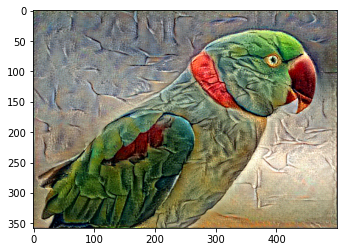

In [17]:
plt.imshow(target.numpy().reshape(target.shape[1:]))
plt.show()

Пикассо!